## Imports

In [63]:
from fastai.tabular.all import *
from datasets import load_dataset


In [2]:
def f(x):
    return x**2

In [7]:
xt = tensor(3.0).requires_grad_()
xt

tensor(3., requires_grad=True)

In [8]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [9]:
yt.backward()

In [10]:
xt.grad

tensor(6.)

In [12]:
xt = tensor([3.0, 4.0, 10.0]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [13]:
def f(x):
    return (x**2).sum()


yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [14]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

w = -= w.grad * lr

In [15]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

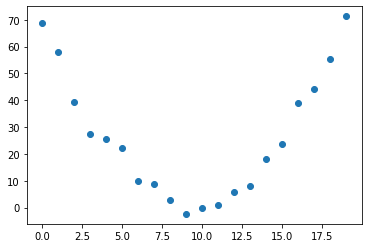

In [16]:
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1
plt.scatter(time, speed);

In [21]:
def f(t, params):
    a, b, c = params
    return a * (t**2) + (b * t) + c

In [22]:
def mse(preds, targets):
    return ((preds - targets) ** 2).mean()

In [60]:
params = torch.randn(3).requires_grad_()

In [42]:
preds = f(time, params)

In [43]:
def show_preds(preds, ax=None):
    if ax is None:
        ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

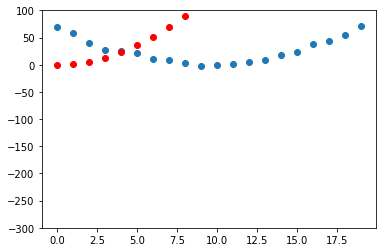

In [44]:
show_preds(preds)

In [45]:
loss = mse(preds, speed)
loss

tensor(43393.8555, grad_fn=<MeanBackward0>)

In [46]:
loss.backward()
params.grad

tensor([69336.5391,  4461.5532,   288.1797])

In [47]:
params.grad * 1e-5

tensor([0.6934, 0.0446, 0.0029])

In [48]:
params

tensor([ 1.3324,  0.7078, -0.8501], requires_grad=True)

In [49]:
lr = 1e-5
params.data -= lr * params.data
params.grad = None

In [50]:
preds = f(time, params)
mse(preds, speed)

tensor(43392.9102, grad_fn=<MeanBackward0>)

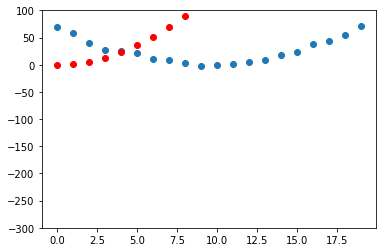

In [51]:
show_preds(preds)

In [61]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds

In [53]:
for i in range(10):
    apply_step(params)

43392.91015625
8755.8916015625
2201.504150390625
961.2107543945312
726.5059814453125
682.0894165039062
673.6812133789062
672.0867309570312
671.7817993164062
671.7206420898438


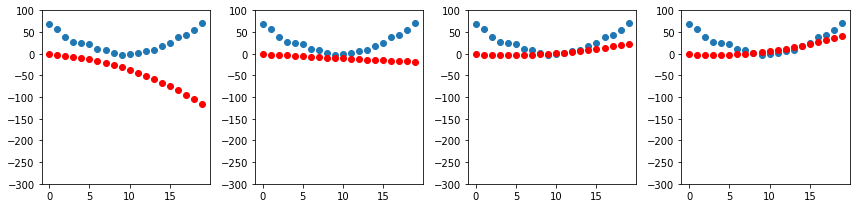

In [62]:
_, axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs:
    show_preds(apply_step(params, False), ax)
plt.tight_layout()

## Binary cross entropy loss function

In [67]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")
nsubjet_ds.set_format("pt")

Using custom data configuration dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4
Reusing dataset parquet (/home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

In [68]:
nsubjet_ds["train"][0]

{'pT': tensor(543.6340),
 'mass': tensor(25.8468),
 'tau_1_0.5': tensor(0.1651),
 'tau_1_1': tensor(0.0327),
 'tau_1_2': tensor(0.0023),
 'tau_2_0.5': tensor(0.0488),
 'tau_2_1': tensor(0.0037),
 'tau_2_2': tensor(4.3910e-05),
 'tau_3_0.5': tensor(0.0310),
 'tau_3_1': tensor(0.0016),
 'tau_3_2': tensor(1.1182e-05),
 'tau_4_0.5': tensor(0.0243),
 'tau_4_1': tensor(0.0011),
 'tau_4_2': tensor(7.7659e-06),
 'tau_5_0.5': tensor(0.0043),
 'tau_5_1': tensor(0.0002),
 'tau_5_2': tensor(7.7060e-07),
 'tau_6_0.5': tensor(0.),
 'tau_6_1': tensor(0.),
 'tau_6_2': tensor(0.),
 'label': tensor(0)}

* Create PyTorch dataset from list of xs and ys
* Define cross entropy
* Define network etc

In [69]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()